任务二：掌握反向传播的编程实现，在全连接神经网络中运行反向传播，并观察效果。
（1）按照函数 $𝑦 = 𝑓(𝑥) = 𝑥^6 + 3𝑥^5 + 4𝑥^4 + 𝑥 + 2 $
生成一组需要拟合的数据。例如取10000组x，其中x服从[-2,2]
间的均匀分布，按照函数计算对应的 𝑦 ，得到数据组
（2）搭建一个全连接神经网络（多层感知机），例如有6层，每个隐藏层有200个神经元（对应200*200权重矩阵）
的全连接神经网络。在神经网络搭建中尝试不同的激活函数，例如ReLu、sigmoid、双曲正切等经典激活函数。
（3）运用神经网络学习数据组 的特征，考虑使用多种损失函数：均方误差（MSE）/平均绝对值
误差（MAE）/交叉熵损失函数等等。
（4）调用反向传播算法计算梯度，运用梯度下降的方法学习神经网络的参数。调试迭代步长（学习率）参数，画
出损失函数图，观察损失函数在迭代中变化情况，记录内存/显存占用和计算时间。

In [19]:

import pandas as pd
import numpy as np

#定义函数
def function(x):
    return x**6+3*x**5+4*x**4+x+2
#生成数据
x=np.random.uniform(-2,2,10000)
y =function(x)

In [85]:
y

array([ 21.26787288,   3.97786399, 177.48694629, ...,   3.40852834,
         1.69933969,   9.95566244])

In [61]:
import psutil
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time

#记录内存和时间
class MemoryAndTimeCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.memory_usage = []
        self.gpu_memory_usage = []
        self.epoch_times = []
        self.start_time = None
    
    def on_epoch_begin(self, epoch, logs=None):
        # 记录每个 epoch 开始时的时间
        self.start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        # 记录 CPU 内存使用情况
        memory = self.process.memory_info().rss / (1024 * 1024)  # 转换为 MB
        self.memory_usage.append(memory)
        
        # 记录 epoch 结束时的时间并计算时间差
        epoch_time = time.time() - self.start_time
        self.epoch_times.append(epoch_time)
        
        # 输出每个 epoch 的时间和内存信息
        print(f"Epoch {epoch+1}: CPU memory usage: {memory:.2f} MB, Time taken: {epoch_time:.2f} seconds")
        if tf.config.list_physical_devices('GPU'):
            print(f"Epoch {epoch+1}: GPU memory usage: {gpu_memory:.2f} MB")

#构建网络和训练
def mlp_tf(x, y, layers, denses, activation, loss, lr, epochs, batch):
    # 数据集划分
    x_train, x_test = x[:8000], x[8000:]
    y_train, y_test = y[:8000], y[8000:]
    
    # 搭建网络
    model = tf.keras.Sequential()

    # 添加输入层
    model.add(tf.keras.layers.Dense(denses, activation=activation, input_shape=(1,)))
    
    # 添加隐藏层
    for _ in range(layers):
        model.add(tf.keras.layers.Dense(denses, activation=activation))
   
    # 添加输出层
    model.add(tf.keras.layers.Dense(1, activation=None))
    
    # 编译模型 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)
    
    # 创建内存和时间监控回调
    memory_time_callback = MemoryAndTimeCallback()
    
    # 训练模型，并记录内存使用情况和时间
    fit = model.fit(x_train, y_train, epochs=epochs, batch_size=batch, validation_data=(x_test, y_test), callbacks=[memory_time_callback])
    
    # 训练结束后，打印内存占用情况和时间
    print("CPU Memory usage per epoch (MB):", memory_time_callback.memory_usage)
    
    print("Time taken per epoch (seconds):", memory_time_callback.epoch_times)

    # 画损失函数图
    plt.plot(fit.history["loss"], label="train loss")
    plt.plot(fit.history["val_loss"], label="validation loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Loss Function During Training")
    plt.legend()
    plt.show()

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # 绘制内存使用情况在第一个 y 轴
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('Memory usage (MB)', color='tab:blue')
    ax1.plot(memory_time_callback.memory_usage, label="CPU memory (MB)", color='tab:blue')
    if memory_time_callback.gpu_memory_usage:
        ax1.plot(memory_time_callback.gpu_memory_usage, label="GPU memory (MB)", color='tab:cyan')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')

    # 创建第二个 y 轴，共享 x 轴
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time per epoch (seconds)', color='tab:orange')
    ax2.plot(memory_time_callback.epoch_times, label="Time per epoch (seconds)", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.legend(loc='upper right')

    # 设置标题
    plt.title("Memory Usage and Time Taken per Epoch")

    # 显示图表
    plt.show()


### 1.学习率的测试

Epoch 1/20
48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 268.0117Epoch 1: CPU memory usage: 680.16 MB, Time taken: 1.34 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 219.3951 - val_loss: 2.4361
Epoch 2/20
38/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6997Epoch 2: CPU memory usage: 680.16 MB, Time taken: 0.20 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9053 - val_loss: 2.2885
Epoch 3/20
49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3617Epoch 3: CPU memory usage: 680.33 MB, Time taken: 0.18 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6112 - val_loss: 4.3466
Epoch 4/20
45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4878Epoch 4: CPU memory usage: 680.33 MB, Time taken: 0.19 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3543 - val_loss: 9.1256
Epoch 5/20
46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5904Epoch 5: CPU memory usage: 680.32 MB, Time taken: 0.20 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1761 - val_loss: 5.7

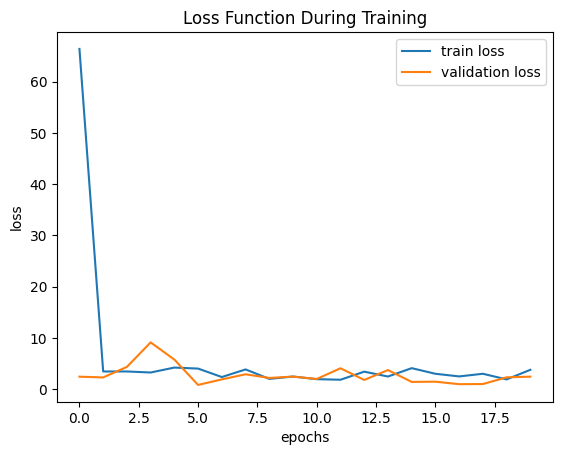

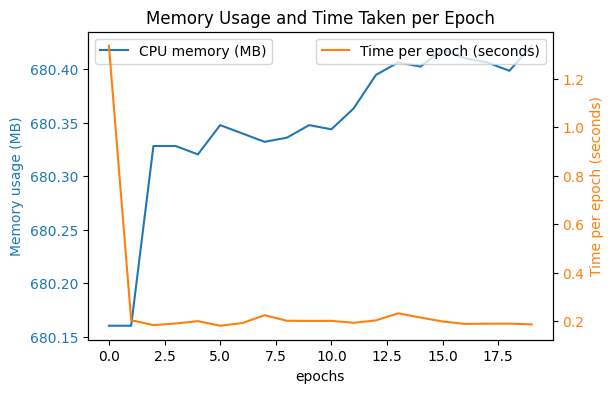

In [64]:
mlp_tf(x,y,layers=4,denses=200,activation='relu',loss='mean_absolute_error',lr=0.1,epochs=20,batch=128)

Epoch 1/20
44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.3333Epoch 1: CPU memory usage: 707.40 MB, Time taken: 1.37 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.7655 - val_loss: 3.3693
Epoch 2/20
48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8810Epoch 2: CPU memory usage: 707.45 MB, Time taken: 0.19 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9638 - val_loss: 1.3227
Epoch 3/20
44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4158Epoch 3: CPU memory usage: 707.47 MB, Time taken: 0.20 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4209 - val_loss: 2.2820
Epoch 4/20
49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3145Epoch 4: CPU memory usage: 707.47 MB, Time taken: 0.19 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4104 - val_loss: 3.0930
Epoch 5/20
48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4305Epoch 5: CPU memory usage: 707.48 MB, Time taken: 0.19 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3554 - val_loss: 4.492

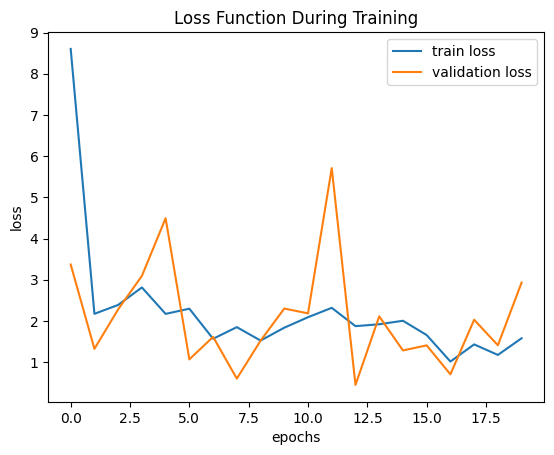

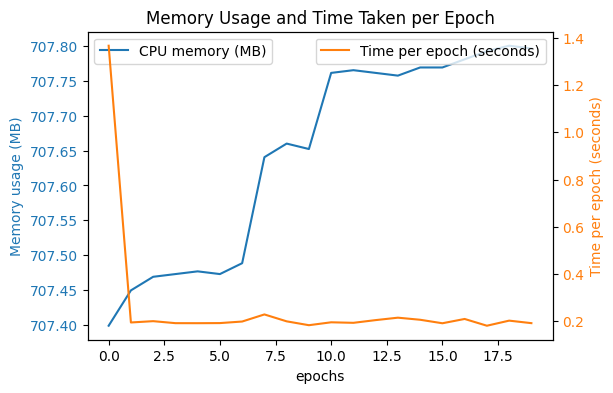

In [65]:
mlp_tf(x,y,layers=4,denses=200,activation='relu',loss='mean_absolute_error',lr=0.01,epochs=20,batch=128)

Epoch 1/20
45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.1681Epoch 1: CPU memory usage: 732.84 MB, Time taken: 1.33 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 20.0009 - val_loss: 12.1594
Epoch 2/20
47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4822 Epoch 2: CPU memory usage: 733.34 MB, Time taken: 0.19 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5125 - val_loss: 0.9517
Epoch 3/20
49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9329Epoch 3: CPU memory usage: 733.96 MB, Time taken: 0.19 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9123 - val_loss: 0.8921
Epoch 4/20
47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6755Epoch 4: CPU memory usage: 734.27 MB, Time taken: 0.19 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6996 - val_loss: 0.5689
Epoch 5/20
48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5964Epoch 5: CPU memory usage: 734.29 MB, Time taken: 0.19 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6180 - val_loss: 0.8

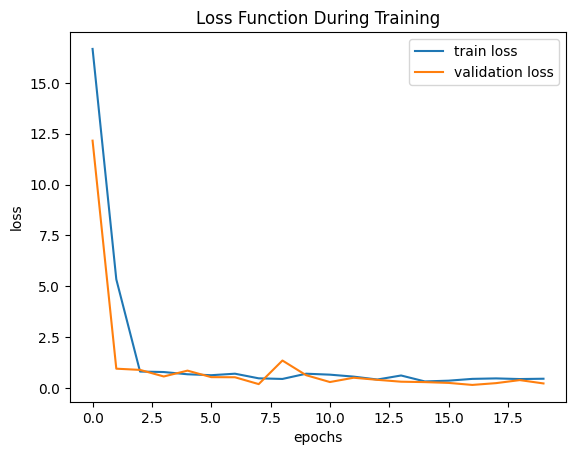

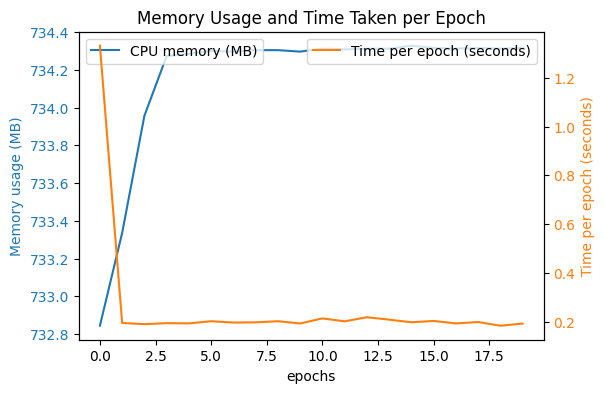

In [66]:
mlp_tf(x,y,layers=4,denses=200,activation='relu',loss='mean_absolute_error',lr=0.001,epochs=20,batch=128)

Epoch 1/20
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.5508Epoch 1: CPU memory usage: 761.87 MB, Time taken: 1.41 seconds
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.4663 - val_loss: 2.0439
Epoch 2/20
104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2843Epoch 2: CPU memory usage: 762.33 MB, Time taken: 0.25 seconds
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2117 - val_loss: 1.7461
Epoch 3/20
100/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1355Epoch 3: CPU memory usage: 762.55 MB, Time taken: 0.25 seconds
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0723 - val_loss: 0.5047
Epoch 4/20
103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6237Epoch 4: CPU memory usage: 762.56 MB, Time taken: 0.24 seconds
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6129 - val_loss: 0.2936
Epoch 5/20
100/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2613Epoch 5: CPU memory usage: 762.57 MB, Time taken: 0.25 seconds
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.23

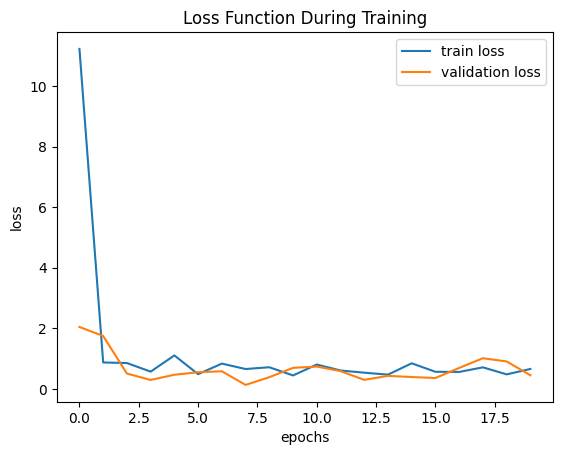

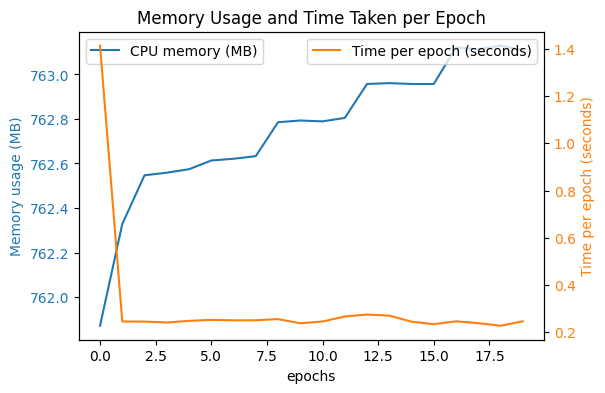

In [67]:
mlp_tf(x,y,layers=4,denses=200,activation='relu',loss='mean_absolute_error',lr=0.001,epochs=20,batch=64)

#### 学习率最好为0.001
### 2. batch的测试

Epoch 1/20
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.4958Epoch 1: CPU memory usage: 790.71 MB, Time taken: 1.32 seconds
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 20.5664 - val_loss: 15.2743
Epoch 2/20
16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.4349 Epoch 2: CPU memory usage: 792.70 MB, Time taken: 0.14 seconds
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.6179 - val_loss: 11.2401
Epoch 3/20
19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.1356 Epoch 3: CPU memory usage: 793.04 MB, Time taken: 0.15 seconds
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0151 - val_loss: 1.7098
Epoch 4/20
20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2563 Epoch 4: CPU memory usage: 793.14 MB, Time taken: 0.14 seconds
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2100 - val_loss: 0.5034
Epoch 5/20
19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2533 Epoch 5: CPU memory usage: 793.19 MB, Time taken: 0.14 seconds
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1769 - val_lo

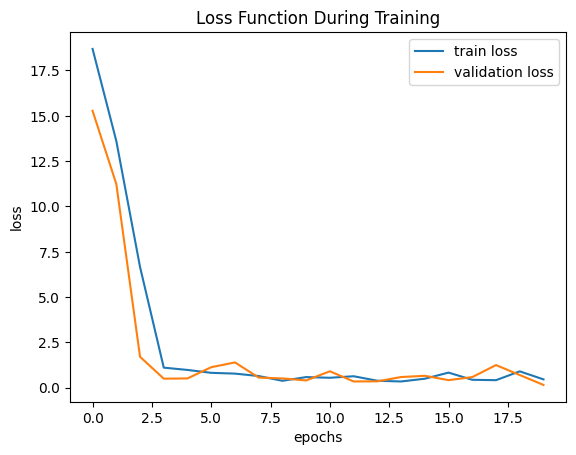

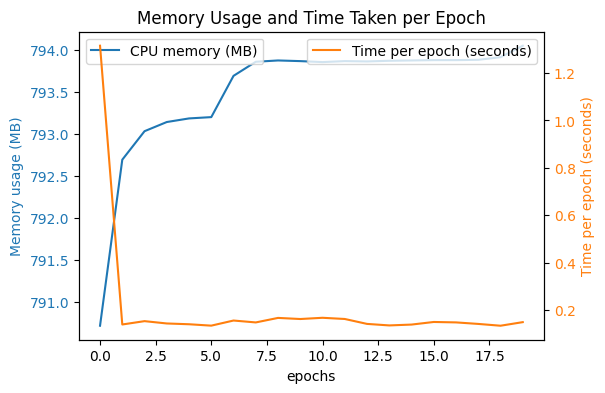

In [68]:
mlp_tf(x,y,layers=4,denses=200,activation='relu',loss='mean_absolute_error',lr=0.001,epochs=20,batch=256)

Epoch 1/20
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.1305Epoch 1: CPU memory usage: 788.26 MB, Time taken: 1.85 seconds
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 22.0092 - val_loss: 18.5805
Epoch 2/20
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.4746 Epoch 2: CPU memory usage: 788.29 MB, Time taken: 0.12 seconds
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17.8641 - val_loss: 15.2743
Epoch 3/20
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.1347 Epoch 3: CPU memory usage: 788.30 MB, Time taken: 0.12 seconds
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.9308 - val_loss: 13.5515
Epoch 4/20
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.0866 Epoch 4: CPU memory usage: 788.29 MB, Time taken: 0.12 seconds
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.9257 - val_loss: 10.6506
Epoch 5/20
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6249  Epoch 5: CPU memory usage: 788.29 MB, Time taken: 0.13 seconds
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2122 -

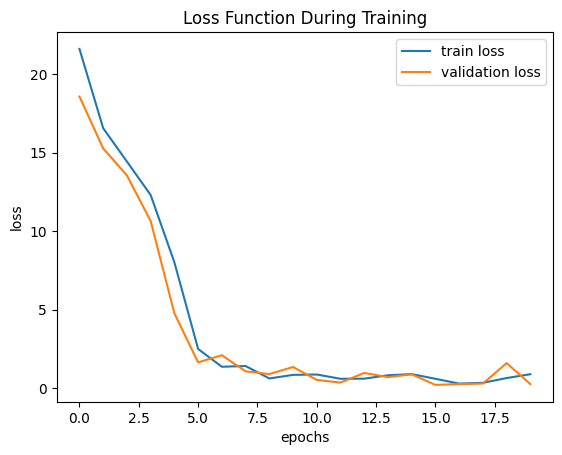

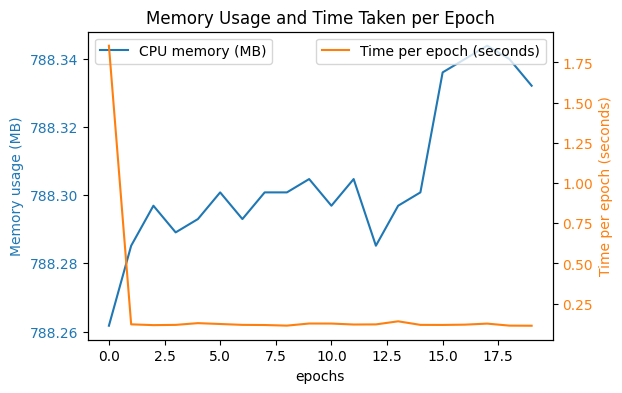

In [69]:
mlp_tf(x,y,layers=4,denses=200,activation='relu',loss='mean_absolute_error',lr=0.001,epochs=20,batch=512)

#### batch最好为128
### 3. 激活函数的测试

Epoch 1/20
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.5170Epoch 1: CPU memory usage: 805.38 MB, Time taken: 1.40 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 20.5417 - val_loss: 21.1825
Epoch 2/20
49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.8600Epoch 2: CPU memory usage: 805.70 MB, Time taken: 0.20 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.8864 - val_loss: 21.1842
Epoch 3/20
46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.6962Epoch 3: CPU memory usage: 805.70 MB, Time taken: 0.20 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.7744 - val_loss: 21.1750
Epoch 4/20
48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.8150Epoch 4: CPU memory usage: 806.58 MB, Time taken: 0.19 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.0491 - val_loss: 20.9110
Epoch 5/20
48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.8271Epoch 5: CPU memory usage: 806.57 MB, Time taken: 0.20 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.6251 - val

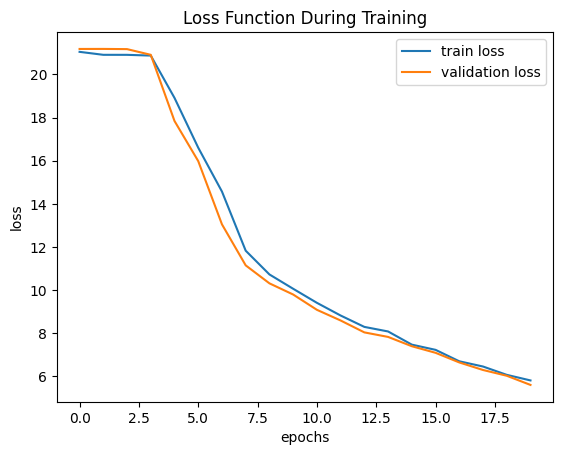

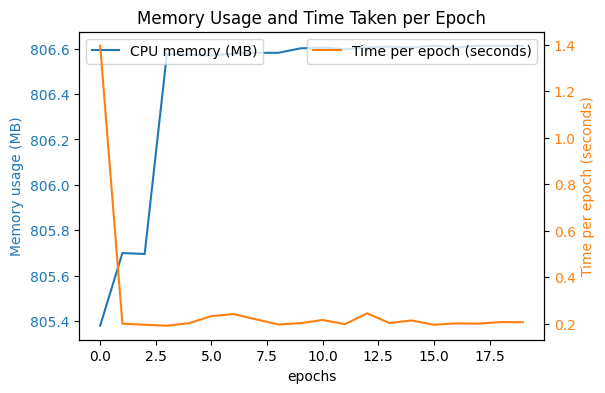

In [72]:
mlp_tf(x,y,layers=4,denses=200,activation='sigmoid',loss='mean_absolute_error',lr=0.001,epochs=20,batch=128)

Epoch 1/20
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.2468Epoch 1: CPU memory usage: 829.13 MB, Time taken: 1.38 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 21.2267 - val_loss: 20.9571
Epoch 2/20
54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.5948Epoch 2: CPU memory usage: 829.86 MB, Time taken: 0.24 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4058 - val_loss: 15.2272
Epoch 3/20
55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.2399Epoch 3: CPU memory usage: 830.50 MB, Time taken: 0.24 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.1572 - val_loss: 12.6590
Epoch 4/20
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.8455Epoch 4: CPU memory usage: 830.51 MB, Time taken: 0.23 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.8218 - val_loss: 12.2245
Epoch 5/20
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.6394Epoch 5: CPU memory usage: 830.53 MB, Time taken: 0.24 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.4981 - val

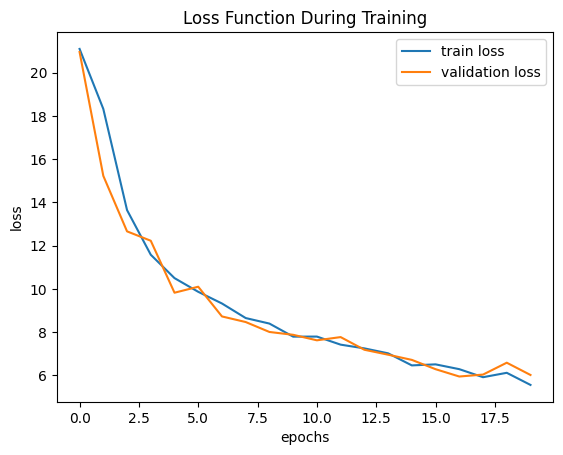

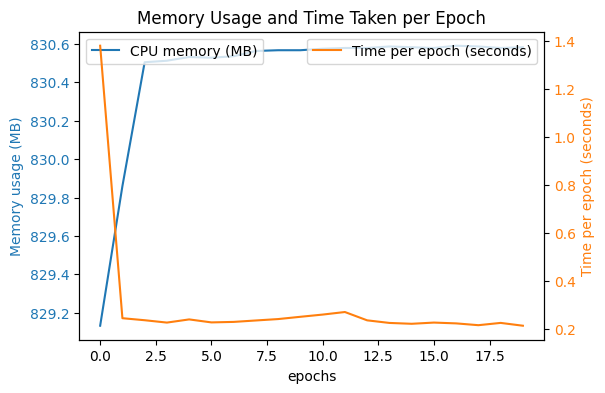

In [73]:
mlp_tf(x,y,layers=4,denses=200,activation='tanh',loss='mean_absolute_error',lr=0.001,epochs=20,batch=128)

#### 激活函数最好为relu
### 4. 损失函数的测试

Epoch 1/20
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1925.5162Epoch 1: CPU memory usage: 799.27 MB, Time taken: 1.49 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1881.4271 - val_loss: 633.8289
Epoch 2/20
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 520.1958Epoch 2: CPU memory usage: 800.09 MB, Time taken: 0.23 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 509.5265 - val_loss: 102.8518
Epoch 3/20
43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.1233Epoch 3: CPU memory usage: 800.08 MB, Time taken: 0.21 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.4067 - val_loss: 4.5750
Epoch 4/20
41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6355Epoch 4: CPU memory usage: 800.24 MB, Time taken: 0.22 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2004 - val_loss: 1.7869
Epoch 5/20
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7059Epoch 5: CPU memory usage: 800.40 MB, Time taken: 0.23 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6730 - v

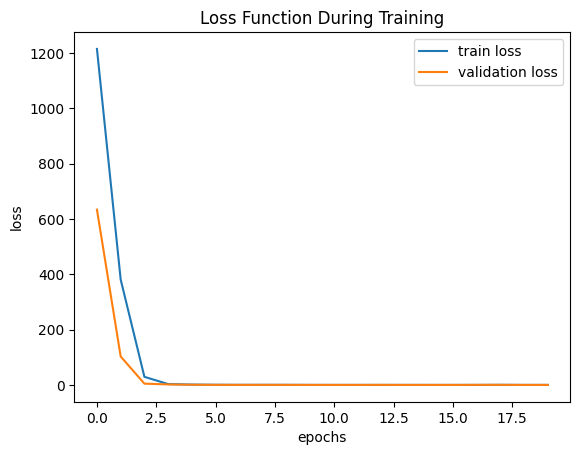

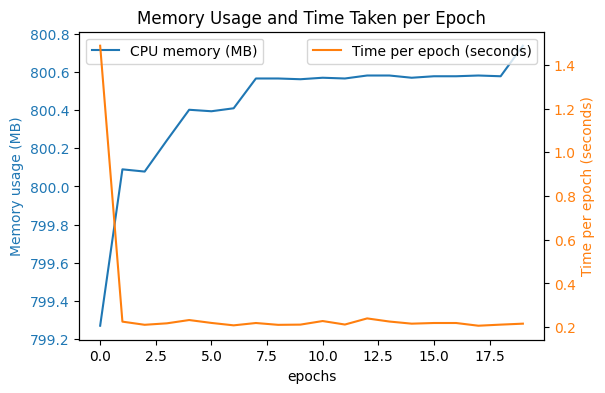

In [74]:
mlp_tf(x,y,layers=4,denses=200,activation='relu',loss='mean_squared_error',lr=0.001,epochs=20,batch=128)

Epoch 1/20
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 376.3411Epoch 1: CPU memory usage: 829.43 MB, Time taken: 1.55 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 376.3693 - val_loss: 381.7813
Epoch 2/20
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 373.5561Epoch 2: CPU memory usage: 829.45 MB, Time taken: 0.23 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 373.7765 - val_loss: 381.7813
Epoch 3/20
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 372.2729Epoch 3: CPU memory usage: 829.84 MB, Time taken: 0.22 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 372.5551 - val_loss: 381.7813
Epoch 4/20
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 377.7506Epoch 4: CPU memory usage: 829.83 MB, Time taken: 0.23 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 377.6624 - val_loss: 381.7813
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 370.6303Epoch 5: CPU memory usage: 830.00 MB, Time taken: 0.22 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

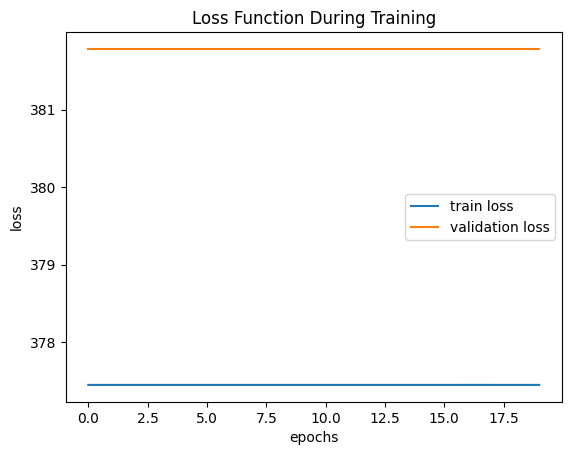

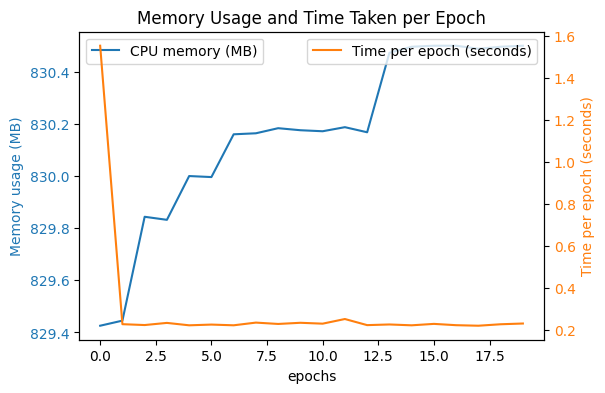

In [75]:
mlp_tf(x,y,layers=4,denses=200,activation='relu',loss='binary_crossentropy',lr=0.001,epochs=20,batch=128)

Epoch 1/20


c:\Users\Lenovo\.conda\envs\test\Lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8738e-06Epoch 1: CPU memory usage: 856.84 MB, Time taken: 1.50 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8677e-06 - val_loss: 2.8237e-06
Epoch 2/20
54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7442e-06Epoch 2: CPU memory usage: 857.34 MB, Time taken: 0.25 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7545e-06 - val_loss: 2.8237e-06
Epoch 3/20
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8047e-06Epoch 3: CPU memory usage: 857.34 MB, Time taken: 0.23 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8025e-06 - val_loss: 2.8237e-06
Epoch 4/20
55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8269e-06Epoch 4: CPU memory usage: 857.35 MB, Time taken: 0.24 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8244e-06 - val_loss: 2.8237e-06
Epoch 5/20
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6879e-06Epoch 5: CPU memory usage: 857.34 MB, Time taken: 0.23 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

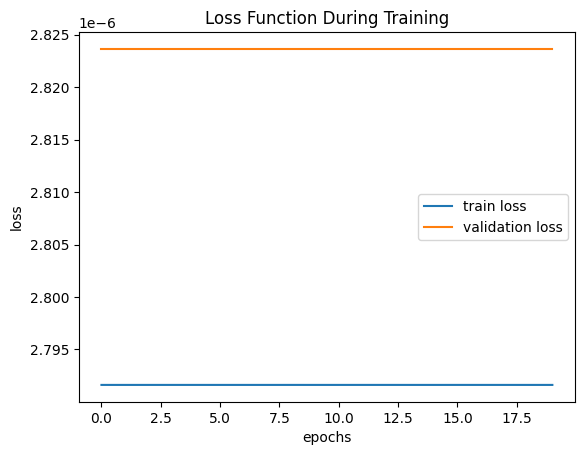

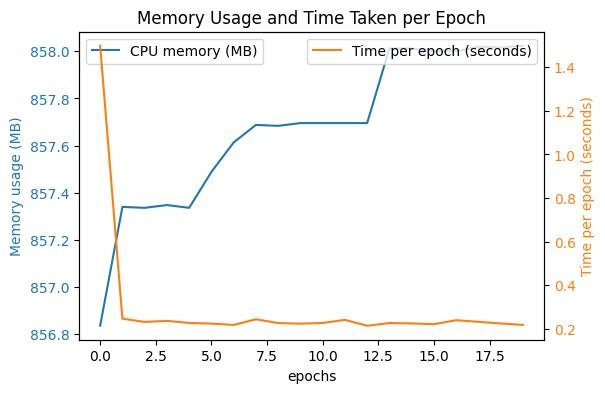

In [76]:
mlp_tf(x,y,layers=4,denses=200,activation='relu',loss='categorical_crossentropy',lr=0.001,epochs=20,batch=128)

In [ ]:
#### 损失函数在mean_squared_error时模型表现最好
### 下文还测试了epochs的数量，发现在epoch为20时模型表现较好且效率较高

Epoch 1/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1870.3925Epoch 1: CPU memory usage: 833.52 MB, Time taken: 1.44 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1851.3024 - val_loss: 669.5884
Epoch 2/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 580.7065Epoch 2: CPU memory usage: 833.54 MB, Time taken: 0.22 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 576.9855 - val_loss: 196.3734
Epoch 3/10
43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.3227Epoch 3: CPU memory usage: 833.54 MB, Time taken: 0.20 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111.5326 - val_loss: 5.2947
Epoch 4/10
52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3620Epoch 4: CPU memory usage: 833.54 MB, Time taken: 0.18 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2164 - val_loss: 0.8793
Epoch 5/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8930Epoch 5: CPU memory usage: 833.55 MB, Time taken: 0.24 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8899 -

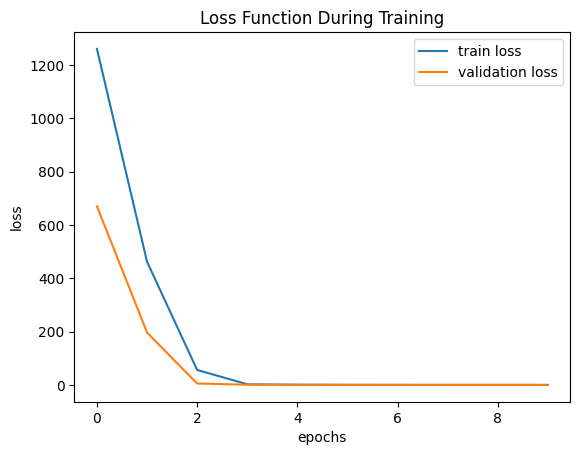

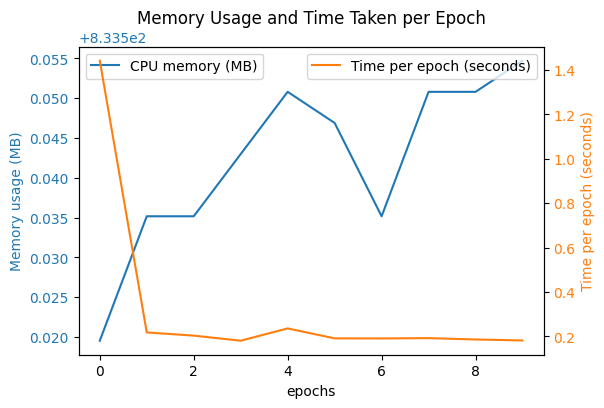

In [79]:
mlp_tf(x,y,layers=4,denses=200,activation='relu',loss='mean_squared_error',lr=0.001,epochs=10,batch=128)

Epoch 1/100
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1828.7809Epoch 1: CPU memory usage: 867.43 MB, Time taken: 1.46 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1793.0187 - val_loss: 662.8498
Epoch 2/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 546.4251Epoch 2: CPU memory usage: 868.34 MB, Time taken: 0.22 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 543.5355 - val_loss: 209.6418
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.6835 Epoch 3: CPU memory usage: 868.99 MB, Time taken: 0.22 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 98.8984 - val_loss: 3.8613
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1531Epoch 4: CPU memory usage: 869.31 MB, Time taken: 0.22 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1430 - val_loss: 1.1763
Epoch 5/100
43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0875Epoch 5: CPU memory usage: 869.43 MB, Time taken: 0.21 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.06

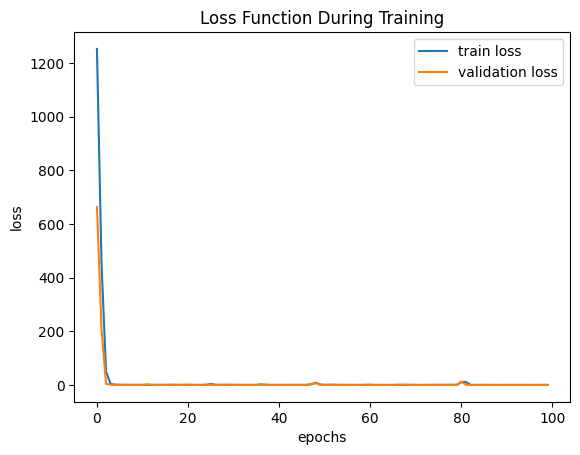

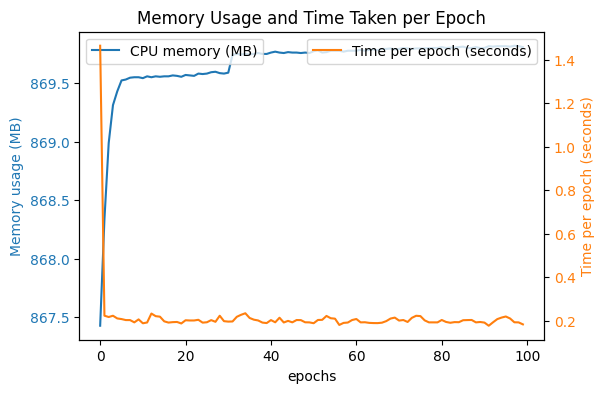

In [77]:
mlp_tf(x,y,layers=4,denses=200,activation='relu',loss='mean_squared_error',lr=0.001,epochs=100,batch=128)